In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
sns.set(style="whitegrid")
os.makedirs("outputs", exist_ok=True)

In [55]:
# Load local CSV files
data= pd.read_csv(r"C:\Users\KalyanMarella\OneDrive - Inspira Enterprise\sales_customer_merged.csv")

In [57]:
# Preprocess and clean data
data.columns = data.columns.str.lower().str.strip().str.replace(" ", "_")

data['sales_amount'] = pd.to_numeric(data['sales_amount'], errors='coerce')
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')
data.dropna(subset=['sales_amount', 'order_date'], inplace=True)

In [58]:
# Load into SQLite
conn = sqlite3.connect("sales_dashboard.db")
data.to_sql("sales_customer_merged", conn, if_exists="replace", index=False)

100

In [59]:

# SQL Queries for KPIs
queries = {
    "total_sales": "SELECT SUM(sales_amount) AS total_sales FROM sales_customer_merged;",
    "monthly_sales": """
        SELECT strftime('%Y-%m', order_date) AS month, 
               SUM(sales_amount) AS total 
        FROM sales_customer_merged
        GROUP BY month 
        ORDER BY month;
    """,
    "yearly_sales": """
        SELECT strftime('%Y', order_date) AS year, 
               SUM(sales_amount) AS total 
        FROM sales_customer_merged 
        GROUP BY year 
        ORDER BY year;
    """,
    "sales_by_country": """
        SELECT country, SUM(sales_amount) AS total 
        FROM sales_customer_merged 
        GROUP BY country;
    """,
    "sales_by_product": """
        SELECT product_id, SUM(sales_amount) AS total 
        FROM sales_customer_merged 
        GROUP BY product_id 
        ORDER BY total DESC;
    """,
    "average_order_value": """
        SELECT SUM(sales_amount)*1.0 / COUNT(order_id) AS aov FROM sales_customer_merged;
    """,
    "customer_lifetime_value": """
        SELECT customer_id, 
               COUNT(order_id) AS total_orders,
               SUM(sales_amount) AS total_sales,
               AVG(sales_amount) AS avg_order_value
        FROM sales_customer_merged
        GROUP BY customer_id;
    """
}



In [60]:

# Run queries and save CSVs
import os
os.makedirs("outputs", exist_ok=True)
results = {}
for name, query in queries.items():
    df = pd.read_sql_query(query, conn)
    results[name] = df
    df.to_csv(f"outputs/{name}.csv", index=False)

In [61]:
# Compute growth rate from monthly sales
monthly = results['monthly_sales'].copy()
monthly['month'] = pd.to_datetime(monthly['month'])
monthly['previous'] = monthly['total'].shift(1)
monthly['growth_rate'] = ((monthly['total'] - monthly['previous']) / monthly['previous']).round(2)
monthly.to_csv("outputs/monthly_growth_rate.csv", index=False)

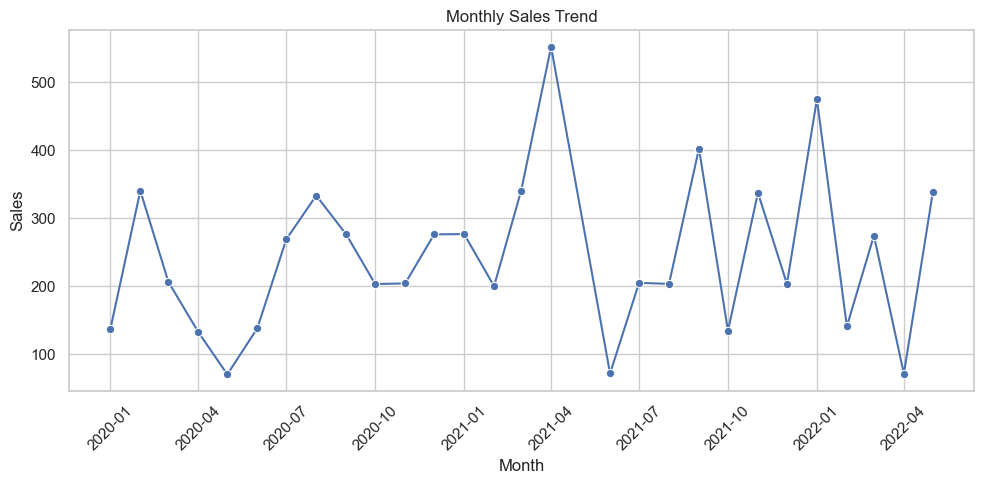

In [62]:
# Visualization
# 1. Monthly Sales Trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly, x='month', y='total', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\KalyanMarella\AppData\Local\Temp\ipykernel_17448\633063157.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly.dropna(), x='month', y='growth_rate', palette="coolwarm")


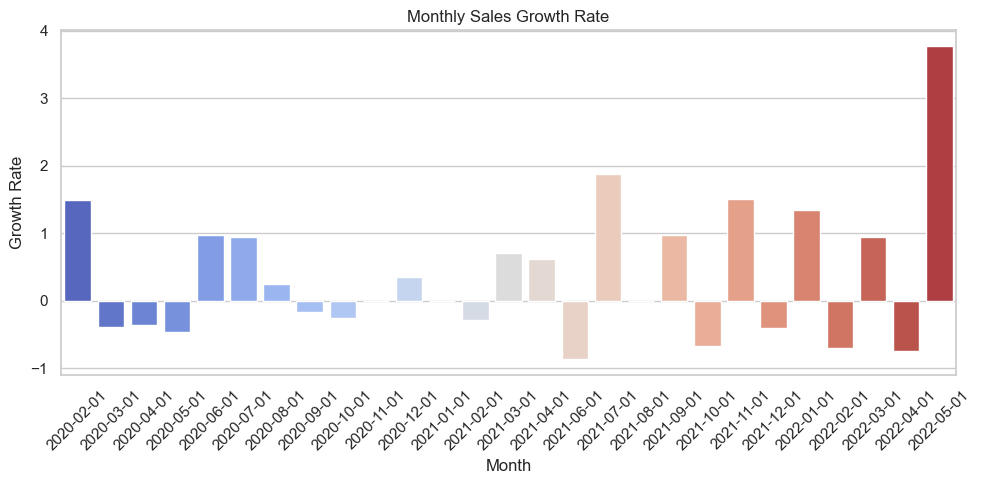

In [63]:
# 2. Growth Rate
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly.dropna(), x='month', y='growth_rate', palette="coolwarm")
plt.title("Monthly Sales Growth Rate")
plt.xlabel("Month")
plt.ylabel("Growth Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

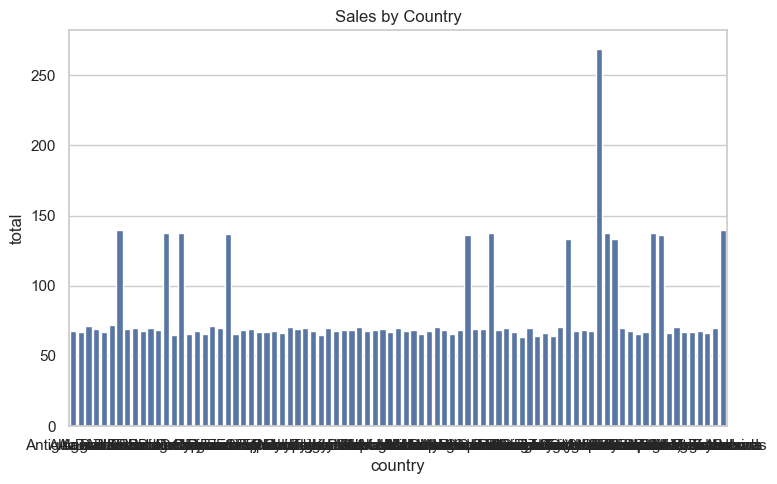

In [66]:
# 3. Sales by Region
plt.figure(figsize=(8, 5))
sns.barplot(data=results['sales_by_country'], x='country', y='total')
plt.title("Sales by Country")
plt.tight_layout()
plt.show()

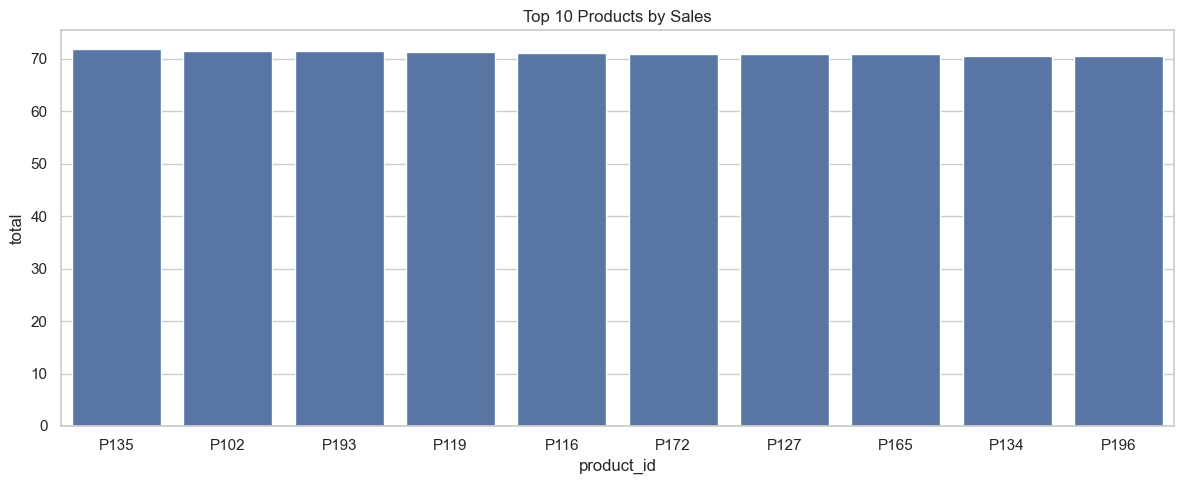

In [67]:
# 4. Top Products
plt.figure(figsize=(12, 5))
top_products = results['sales_by_product'].head(10)
sns.barplot(data=top_products, x='product_id', y='total')
plt.title("Top 10 Products by Sales")
plt.tight_layout()
plt.show()

In [68]:
# Final Step: Close DB connection
conn.close()
print("✅ Analysis complete. All results saved in the 'outputs/' folder.")

✅ Analysis complete. All results saved in the 'outputs/' folder.
